## Proyecto Complementario #1: Evaluando modelos ML

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn import preprocessing
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
df = pd.read_csv('Spotify_Track_Dataset.csv')

## Data Cleaning

In [3]:
df = df.dropna()
df_filtro = df[(np.abs(stats.zscore(df['duration_ms'])) < 3)]
df1 = df_filtro.copy()

## Data Wrangling

In [4]:
df1.drop('Unnamed: 0', axis = 1, inplace = True)
df1['duration_min'] = (df1['duration_ms']/(60 * 1000)).round(2)
df1.drop('duration_ms', axis = 1, inplace = True)
df1['loudness_db'] = - df1['loudness']
df1.drop('loudness', axis = 1, inplace = True)
df1[['artist_1', 'artist_2', 'artist_3']] = df1['artists'].str.split(';', 2, expand=True)
df1.drop('artists', axis = 1, inplace = True)

## Preprocesado

In [5]:
ord_enc = preprocessing.OrdinalEncoder()
df1['track_genre'] = ord_enc.fit_transform(df1[['track_genre']])
df1['track_genre']

X = df1.drop(['track_genre', 'track_id', 'album_name', 'track_name', 'explicit', 'mode', 'key', 'time_signature', 'artist_1', 'artist_2', 'artist_3'], axis = 1) 

y = df1['track_genre']

X2 = X.iloc[::15,:] 
y2 = y.iloc[::15]

## Selección de modelos de ML

A continuación se probarán distintos modelos de clasificación y se evaluarán las métricas obtenidas. Los algoritmos empleados son KNeighbors, Gaussian Naive Bayes, Decision tree y Randon Forest. Se probaron otros algoritmos tales como SVC, Quadratic Discriminant, Ada Boost, etcétera, pero no funcionaron adecuadamente o no eran extremadamente lentos.

Para cada algoritmo se empleó el Forward Feature Selector para determinar las 3, 5, 7, 9 y 10 variables que el algoritmo considera más relevantes (Sprint 3, Sprint 5, Sprint 7, Sprint 9 y Sprint 10, respectivamente). Y luego para cada Sprint se aplicó el algoritmo y se calculan las métricas.

Cómo métrica de bondad de ajuste se encuentra Mean Absolute Error (MAE) la cual será utilizada para dilucidar posibles casos de under o overfitting.

### KNeighbors Classifier

In [6]:
from sklearn.neighbors import KNeighborsClassifier

In [7]:
knn = KNeighborsClassifier(n_neighbors = 5, n_jobs = -1)

forw = {}

for i in [3, 5, 7, 9, 10]:
    forw[f'sfs_{i}'] = SequentialFeatureSelector(knn, n_features_to_select = i)
    forw[f'sfs_{i}'].fit(X2, y2)
    # print(f'Las {i} variables seleccionadas son:', list(X2.columns[forw[f'sfs_{i}'].get_support()]))
    forw[f'sfs_{i}_var'] = X2.columns[forw[f'sfs_{i}'].get_support()]

In [8]:
knn = KNeighborsClassifier(n_neighbors = 5, n_jobs = -1)

accuracy_forw, recall_forw, f1_forw = [], [], []

for i in [3, 5, 7, 9, 10]:
    X_i = X[list(X2.columns[forw[f'sfs_{i}'].get_support()])]
    
    X_train, X_test, y_train, y_test = train_test_split(X_i, y, random_state = 42)
    knn.fit(X_train, y_train)
    
    y_test_pred = knn.predict(X_test)
    
    accuracy_forw.append(accuracy_score(y_test, y_test_pred))
    recall_forw.append(recall_score(y_test, y_test_pred, average = 'macro'))
    f1_forw.append(f1_score(y_test, y_test_pred, average = 'macro'))
    
comparacion_forw = pd.DataFrame({'Modelo': ['Sprint 3', 'Sprint 5', ' Sprint 7', 'Sprint 9', 'Sprint 10'], 'Accuracy': accuracy_forw, 'Recall': recall_forw, 'F1': f1_forw})

comparacion_forw.round(2)

,Modelo,Accuracy,Recall,F1
0,Sprint 3,0.13,0.13,0.13
1,Sprint 5,0.16,0.16,0.16
2,Sprint 7,0.19,0.19,0.19
3,Sprint 9,0.20,0.20,0.20
4,Sprint 10,0.18,0.18,0.18


### Gaussian Naive Bayes

In [9]:
from sklearn.naive_bayes import GaussianNB

In [10]:
nb = GaussianNB()

forw_nb = {}

for i in [3, 5, 7, 9, 10]:
    forw_nb[f'sfs_{i}'] = SequentialFeatureSelector(nb, n_features_to_select = i)
    forw_nb[f'sfs_{i}'].fit(X2, y2)
    # print(f'Las {i} variables seleccionadas son:', list(X2.columns[forw_nb[f'sfs_{i}'].get_support()]))
    forw_nb[f'sfs_{i}_var'] = X2.columns[forw_nb[f'sfs_{i}'].get_support()]

In [11]:
nb = GaussianNB()

accuracy_forw_nb, recall_forw_nb, f1_forw_nb = [], [], []

for i in [3, 5, 7, 9, 10]:
    X_i = X[list(X2.columns[forw_nb[f'sfs_{i}'].get_support()])]
    
    X_train, X_test, y_train, y_test = train_test_split(X_i, y, random_state = 42)
    nb.fit(X_train, y_train)
    
    y_test_pred = nb.predict(X_test)
    
    accuracy_forw_nb.append(accuracy_score(y_test, y_test_pred))
    recall_forw_nb.append(recall_score(y_test, y_test_pred, average = 'macro'))
    f1_forw_nb.append(f1_score(y_test, y_test_pred, average = 'macro'))
    
comparacion_forw_nb = pd.DataFrame({'Modelo': ['Sprint 3', 'Sprint 5', ' Sprint 7', 'Sprint 9', 'Sprint 10'], 'Accuracy': accuracy_forw_nb, 'Recall': recall_forw_nb, 'F1': f1_forw_nb})

comparacion_forw_nb.round(2)

,Modelo,Accuracy,Recall,F1
0,Sprint 3,0.11,0.11,0.07
1,Sprint 5,0.15,0.15,0.11
2,Sprint 7,0.17,0.17,0.13
3,Sprint 9,0.18,0.19,0.14
4,Sprint 10,0.18,0.18,0.14


### Decision Tree Classifier

In [12]:
from sklearn.tree import DecisionTreeClassifier

In [13]:
dtc = DecisionTreeClassifier(min_samples_split = 10)

forw_dtc = {}

for i in [3, 5, 7, 9, 10]:
    forw_dtc[f'sfs_{i}'] = SequentialFeatureSelector(dtc, n_features_to_select = i)
    forw_dtc[f'sfs_{i}'].fit(X2, y2)
    # print(f'Las {i} variables seleccionadas son:', list(X2.columns[forw_dtc[f'sfs_{i}'].get_support()]))
    forw_dtc[f'sfs_{i}_var'] = X2.columns[forw_dtc[f'sfs_{i}'].get_support()]

In [14]:
dtc = DecisionTreeClassifier(min_samples_split = 10)

accuracy_forw_dtc, recall_forw_dtc, f1_forw_dtc = [], [], []

for i in [3, 5, 7, 9, 10]:
    X_i = X[list(X2.columns[forw_dtc[f'sfs_{i}'].get_support()])]
    
    X_train, X_test, y_train, y_test = train_test_split(X_i, y, random_state = 42)
    dtc.fit(X_train, y_train)
    
    y_test_pred = dtc.predict(X_test)

    accuracy_forw_dtc.append(accuracy_score(y_test, y_test_pred))
    recall_forw_dtc.append(recall_score(y_test, y_test_pred, average = 'macro'))
    f1_forw_dtc.append(f1_score(y_test, y_test_pred, average = 'macro'))
    
comparacion_forw_dtc = pd.DataFrame({'Modelo': ['Sprint 3', 'Sprint 5', ' Sprint 7', 'Sprint 9', 'Sprint 10'], 'Accuracy': accuracy_forw_dtc, 'Recall': recall_forw_dtc, 'F1': f1_forw_dtc})

comparacion_forw_dtc.round(2)

,Modelo,Accuracy,Recall,F1
0,Sprint 3,0.13,0.14,0.13
1,Sprint 5,0.18,0.19,0.19
2,Sprint 7,0.20,0.21,0.20
3,Sprint 9,0.22,0.22,0.22
4,Sprint 10,0.22,0.22,0.22


### Random Forrest 

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
rfc = RandomForestClassifier(max_depth = 5, n_estimators = 10, max_features = 1)

forw_rfc = {}

for i in [3, 5, 7, 9, 10]:
    forw_rfc[f'sfs_{i}'] = SequentialFeatureSelector(rfc, n_features_to_select = i)
    forw_rfc[f'sfs_{i}'].fit(X2, y2)
    # print(f'Las {i} variables seleccionadas son:', list(X2.columns[forw_rfc[f'sfs_{i}'].get_support()]))
    forw_rfc[f'sfs_{i}_var'] = X2.columns[forw_rfc[f'sfs_{i}'].get_support()]

In [17]:
rfc = RandomForestClassifier(max_depth = 5, n_estimators = 10, max_features = 1)

accuracy_forw_rfc, recall_forw_rfc, f1_forw_rfc = [], [], []

for i in [3, 5, 7, 9, 10]:
    X_i = X[list(X2.columns[forw_rfc[f'sfs_{i}'].get_support()])]
    
    X_train, X_test, y_train, y_test = train_test_split(X_i, y, random_state = 42)
    rfc.fit(X_train, y_train)
    
    y_test_pred = rfc.predict(X_test)
    
    accuracy_forw_rfc.append(accuracy_score(y_test, y_test_pred))
    recall_forw_rfc.append(recall_score(y_test, y_test_pred, average = 'macro'))
    f1_forw_rfc.append(f1_score(y_test, y_test_pred, average = 'macro'))
    
comparacion_forw_rfc = pd.DataFrame({'Modelo': ['Sprint 3', 'Sprint 5', ' Sprint 7', 'Sprint 9', 'Sprint 10'], 'Accuracy': accuracy_forw_rfc, 'Recall': recall_forw_rfc, 'F1': f1_forw_rfc})

comparacion_forw_rfc.round(2)

,Modelo,Accuracy,Recall,F1
0,Sprint 3,0.13,0.13,0.08
1,Sprint 5,0.14,0.14,0.09
2,Sprint 7,0.15,0.15,0.10
3,Sprint 9,0.17,0.17,0.11
4,Sprint 10,0.16,0.16,0.11


### Ada Boost Classifier

Este algoritmo resulta extremandamente lento a la hora de realizar el Forward Feature Selector, es por ello que se tomaron los features determinados por Random Forest.

In [18]:
from sklearn.ensemble import AdaBoostClassifier

In [19]:
abc = AdaBoostClassifier()

accuracy_forw_abc, recall_forw_abc, f1_forw_abc = [], [], []

for i in [3, 5, 7, 9, 10]:
    X_i = X[list(X2.columns[forw_rfc[f'sfs_{i}'].get_support()])]
    
    X_train, X_test, y_train, y_test = train_test_split(X_i, y, random_state = 42)
    abc.fit(X_train, y_train)
    
    y_test_pred = abc.predict(X_test)
    
    accuracy_forw_abc.append(accuracy_score(y_test, y_test_pred))
    recall_forw_abc.append(recall_score(y_test, y_test_pred, average = 'macro'))
    f1_forw_abc.append(f1_score(y_test, y_test_pred, average = 'macro'))
    
comparacion_forw_abc = pd.DataFrame({'Modelo': ['Sprint 3', 'Sprint 5', ' Sprint 7', 'Sprint 9', 'Sprint 10'], 'Accuracy': accuracy_forw_abc, 'Recall': recall_forw_abc, 'F1': f1_forw_abc})

comparacion_forw_abc.round(2)

,Modelo,Accuracy,Recall,F1
0,Sprint 3,0.07,0.06,0.03
1,Sprint 5,0.10,0.10,0.06
2,Sprint 7,0.10,0.10,0.05
3,Sprint 9,0.12,0.12,0.09
4,Sprint 10,0.12,0.12,0.08


## Evaluando underfitting y overfitting

En esta sección se utilizará la métrica "accuracy" para evaluar cuando un algoritmo de ML se encuentra en under/over-fitting. En particular, el método utilizado es el Random Forest Classifier, calcularemos la métrica accuracy, para evaluar la perfomance en el train dataset y en el test dataset mientras variamos la complejidad del algoritmo.

In [20]:
train_metric, test_metric = [], []

X_9 = X[list(X2.columns[forw_dtc['sfs_9'].get_support()])]
X_train, X_test, y_train, y_test = train_test_split(X_9, y, random_state = 42)

k = np.arange(20, 100, 10)

for i in k:
    rfc = RandomForestClassifier(n_estimators = i, max_depth = 5, max_features = 1)
    rfc.fit(X_train, y_train)

    # Evaluamos en el train dataset
    y_train_pred = rfc.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_metric.append(train_acc)

    # Evaluamos en el test dataset
    y_test_pred = rfc.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_metric.append(test_acc)

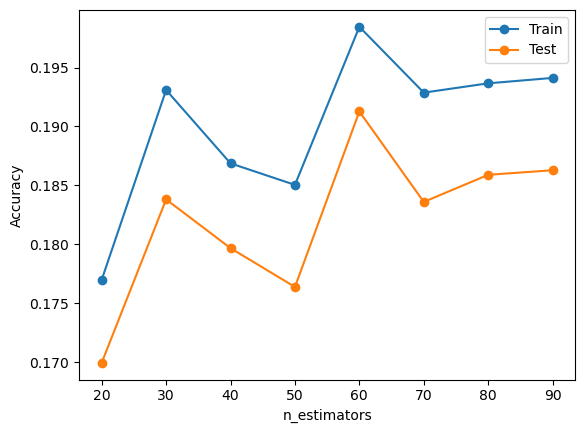

In [21]:
plt.plot(k, train_metric, '-o', label = 'Train')
plt.plot(k, test_metric, '-o', label = 'Test')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.show()

En la figura se graficó la métrica accuracy evaluada para el dataset de entrenamiento y el de evaluación en función de n_estimators. Se observa que con un pequeño aumento de n_estimators el accuracy tanto para train como para test aumentan en forma similar hasta n_estimators = 60. Mayores incrementos de la variable independiente no producen mejoras sustanciales en la calidad del ajuste. Repetimos el proceso, ahora variando max_depth mientras n_estimators = 60.

In [33]:
train_metric_2, test_metric_2 = [], []

k = np.arange(2, 20, 2)

for i in k:
    rtc = RandomForestClassifier(max_depth = i, n_estimators = 60, max_features = 1)
    rtc.fit(X_train, y_train)

    # Evaluamos en el train dataset
    y_train_pred = rtc.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_metric_2.append(train_acc)

    # Evaluamos en el test dataset
    y_test_pred = rtc.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_metric_2.append(test_acc)

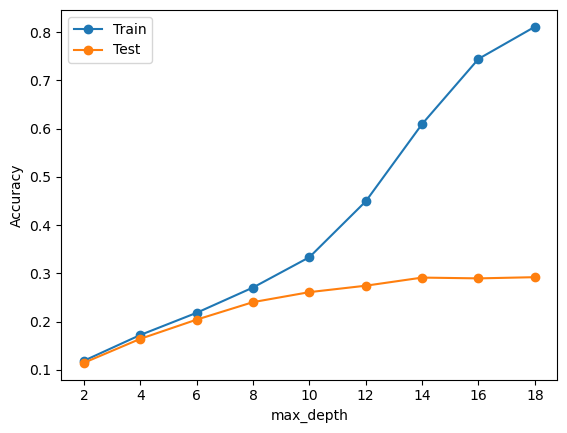

In [34]:
plt.plot(k, train_metric_2, '-o', label = 'Train')
plt.plot(k, test_metric_2, '-o', label = 'Test')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.show()

En la figura se graficaron las métricas accuracy evaluadas para el dataset de entrenamiento y el de evaluación en función de max depth. Se observa que a bajos valores ambas curvas son muy similares pero en torno a max depth = 10 estas se empiezan a separar. En este momento es cuando el algoritmo empieza a sobreajustar. Ahora variamos min_samples_split mientras n_estimators = 60 y max_depth = 10.

In [35]:
train_metric_3, test_metric_3 = [], []

k = np.arange(2, 20, 2)

for i in k:
    rtc = RandomForestClassifier(n_estimators = 60, max_depth = 10, min_samples_split = i)
    rtc.fit(X_train, y_train)

    # Evaluamos en el train dataset
    y_train_pred = rtc.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_metric_3.append(train_acc)

    # Evaluamos en el test dataset
    y_test_pred = rtc.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_metric_3.append(test_acc)

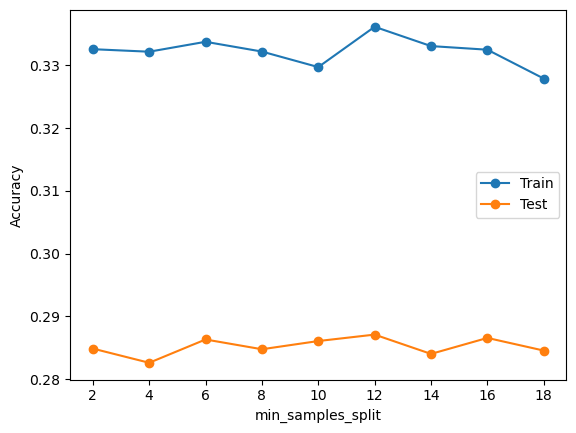

In [36]:
plt.plot(k, train_metric_3, '-o', label = 'Train')
plt.plot(k, test_metric_3, '-o', label = 'Test')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.show()

En este caso obtenemos un máximo de accuracy a min_sample_split = 6, a mayores valores de la variable la métrica se mantiene aproximadamente constante. Por ello selecciomamos min_sample_split = 6 dado que nos da el mejor resultado al tiempo que evitamos hacer más complejo el modelo. Ejecutamos el modelo de Random Forest para n_estimators = 60, max_depth = 10 y min_samples_split = 6.

In [37]:
rtc = RandomForestClassifier(n_estimators = 60, max_depth = 10, min_samples_split = 6)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
rtc.fit(X_train, y_train)
y_pred = rtc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average = 'macro')
f1 = f1_score(y_test, y_pred, average = 'macro')

print(f'''Las métricas obtenidas son: \n Accuracy = {accuracy.round(2)} \n Recall = {recall.round(2)} \n F1 = {f1.round(2)}''')

Las métricas obtenidas son: 
 Accuracy = 0.28 
 Recall = 0.29 
 F1 = 0.25


Por medio de este análisis, logramos mejorar las métricas del modelo de Random Forest al tiempo que evitamos sub y sobreajustar y manteniendo el modelo lo más simple posible. 

## Método de clustering (KMeans)

A continuación probaremos y evaluareamos el método de clustering KMeans. Aplicaremos el método del codo (Elbow Method) para determinar el número adecuado de clusters. El fin de este método es para agrupar las canciones en grupos que excedan simplemente su género musical, identificando grupos de canciones con características similares.

In [27]:
from sklearn.cluster import KMeans

In [28]:
X = df1.drop(['track_genre', 'track_id', 'album_name', 'track_name', 'explicit', 'mode', 'key', 'time_signature', 'artist_1', 'artist_2', 'artist_3'], axis = 1) 

wcss = []

for k in range(2, 20): 
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

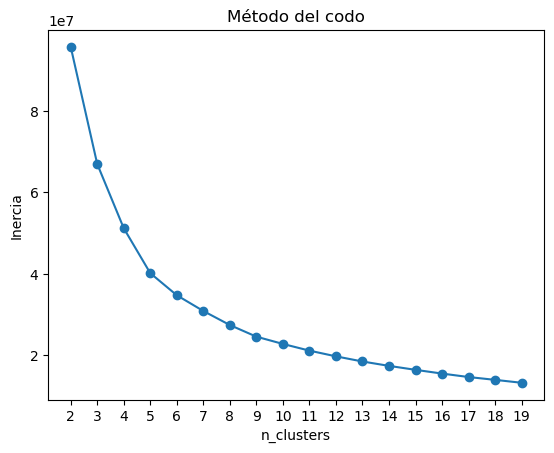

In [29]:
plt.plot(np.arange(2, 20, 1), wcss, '-o')
plt.xlabel('n_clusters')
plt.ylabel('Inercia')
plt.xticks(np.arange(2,20))
plt.title('Método del codo')
plt.show()

El gráfico muestra que la inercia, suma de las distancias de los puntos a su centroide más cercano, disminuye rápidamente a valores n_clusters chicos pero que luego se ameseta. Tomamos n_clusters = 8 como el óptimo ya que a partir de este valor la inercia disminuye lentamente. Ahora evaluamos en n_clusters = 8.

In [30]:
kmeans = KMeans(n_clusters = 8, init = 'k-means++', random_state = 42) 
y_kmeans = kmeans.fit_predict(X)

In [31]:
X['pred'] = y_kmeans
X.groupby(['pred']).mean(numeric_only = True).round(2)

,popularity,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_min,loudness_db
pred,,,,,,,,,,,
0,5.51,0.61,0.66,0.07,0.26,0.22,0.19,0.51,126.03,3.82,8.31
1,32.77,0.59,0.65,0.08,0.35,0.13,0.24,0.51,106.50,3.71,8.33
2,34.41,0.57,0.69,0.08,0.27,0.15,0.24,0.48,137.82,3.92,7.65
3,60.25,0.62,0.64,0.07,0.28,0.14,0.18,0.45,124.99,3.75,7.87
4,9.25,0.53,0.54,0.11,0.45,0.18,0.21,0.44,87.16,3.52,9.88
5,51.75,0.50,0.71,0.10,0.26,0.08,0.22,0.51,169.08,3.63,6.80
6,54.15,0.55,0.56,0.08,0.39,0.14,0.20,0.44,86.42,3.61,9.23
7,13.97,0.49,0.74,0.11,0.23,0.17,0.21,0.49,172.18,3.69,6.87


Estas son las variables medias de los ocho clusters identificados por KMeans. Las variaciones entre grupo y grupo son leves y complejas de analizar. Sin embargo, se observan grupos que se destacan por su "energy", otros por poseer mas "acousticness" y otros por tener mayor "loudness_db". 

## Conclusiones

En esta práctica se evaluaron varios modelos de clasificación, obteniendo en general, métricas muy mejorables. Claramente hay espacio para mejora. Se especula que por medio de la normalización de las diferentes variables y por medio de una mejor seleccion de hiperparámetros estos modelos mejoren sustancialmente.

Empleando el clasificador Random Forest se analizó el efecto de tres de sus hiperparámetros en la métrica accuracy. Esto permitió ir encontrando el mejor modelo, mejorando el ajuste al tiempo que analizamos el sub y sobreajuste.

Por último, se hizo una prueba rápida con el algoritmo de clustering KMeans. Se encontraron ocho posibles cluster con los que agrupar las distintas canciones. Las diferencias medias entre las variables de cada grupo son sutiles y requiere de un análisis concienzudo.